<a href="https://colab.research.google.com/github/Viniciusp67/Consultor-de-Direito-Eleitoral/blob/main/LTSM_Cripto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install tensorflow
!pip install plotly
!pip install yfinance

In [2]:
# Importação de Bibliotecas
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.model_selection import train_test_split

In [3]:
#Escolhendo ação aser trabalhada
cripto = "ETH-USD"
inicio = "2016-01-01"
final = "2024-12-31"

dados_cripto = yf.download(cripto, start=inicio, end=final)
print(dados_cripto.head())

[*********************100%%**********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2017-11-09  308.644989  329.451996  307.056000  320.884003  320.884003   
2017-11-10  320.670990  324.717987  294.541992  299.252991  299.252991   
2017-11-11  298.585999  319.453003  298.191986  314.681000  314.681000   
2017-11-12  314.690002  319.153015  298.513000  307.907990  307.907990   
2017-11-13  307.024994  328.415009  307.024994  316.716003  316.716003   

                Volume  
Date                    
2017-11-09   893249984  
2017-11-10   885985984  
2017-11-11   842300992  
2017-11-12  1613479936  
2017-11-13  1041889984  


In [4]:
#Selecionando campo para trabalhar
dados_selecionados = dados_cripto[['Close']]

# Resetando o índice para garantir que 'Date' se torne uma coluna
dados_selecionados.reset_index(inplace=True)

# Renomeando a coluna 'Date' para 'Data
dados_selecionados.rename(columns={'Date': 'Data'}, inplace=True)
dados_selecionados.rename(columns={'Close': 'preco_fechamento'}, inplace=True)

# Exibindo as primeiras linhas do DataFrame selecionado
print(dados_selecionados.head())

        Data  preco_fechamento
0 2017-11-09        320.884003
1 2017-11-10        299.252991
2 2017-11-11        314.681000
3 2017-11-12        307.907990
4 2017-11-13        316.716003


<ipython-input-4-2aae3924b943>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_selecionados.rename(columns={'Date': 'Data'}, inplace=True)
<ipython-input-4-2aae3924b943>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_selecionados.rename(columns={'Close': 'preco_fechamento'}, inplace=True)


In [5]:
#Ajustando index
df_cripto_fec = dados_selecionados.set_index(pd.DatetimeIndex(dados_selecionados['Data'].values))
df_cripto_fec.drop('Data', axis=1, inplace=True)
df_cripto_fec

,preco_fechamento
2017-11-09,320.884003
2017-11-10,299.252991
2017-11-11,314.681000
2017-11-12,307.907990
2017-11-13,316.716003
...,...
2024-06-27,3444.800537
2024-06-28,3373.635986
2024-06-29,3372.967773
2024-06-30,3432.889160


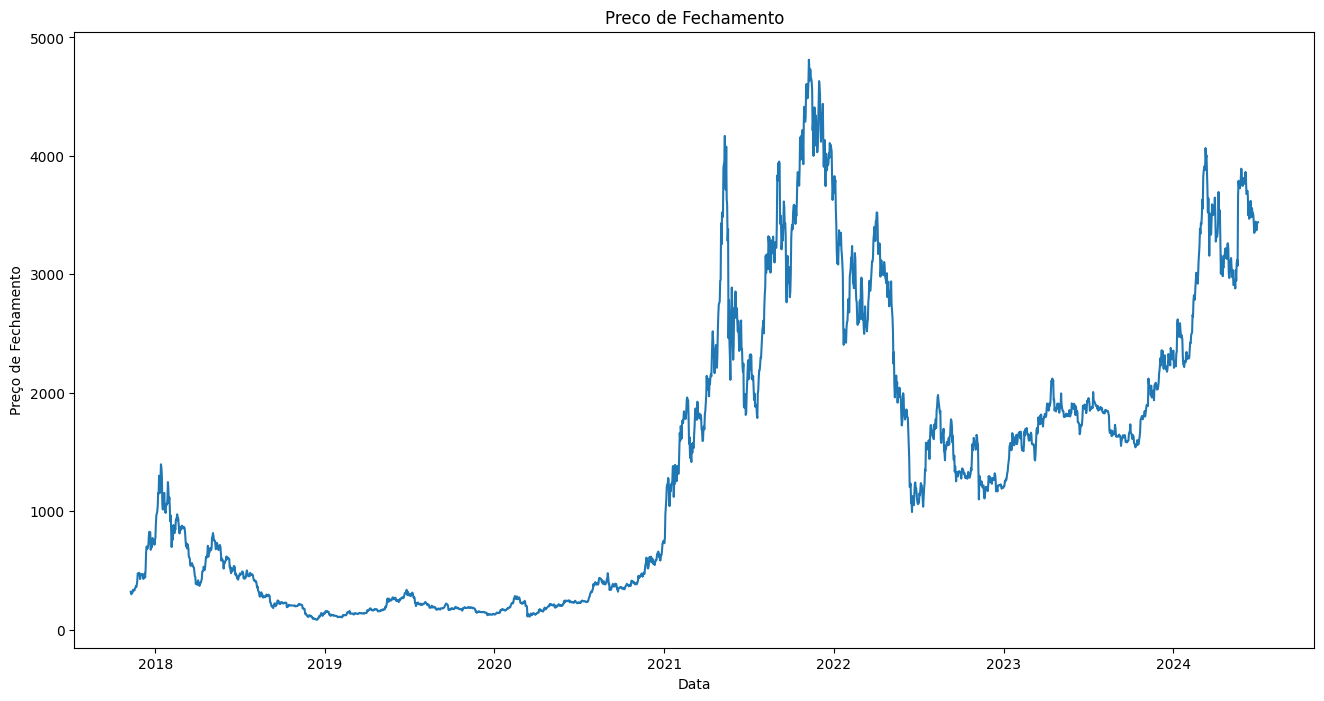

In [6]:
#Plotando informação
plt.figure(figsize=(16,8))
plt.title("Preco de Fechamento")
plt.plot(df_cripto_fec['preco_fechamento'])
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.show()

In [7]:
#Verificar numero de linhas
qtd_linhas = len(df_cripto_fec)
qtd_linhas_treino = round(.70 * qtd_linhas)
qtd_linhas_teste = qtd_linhas - qtd_linhas_treino

info = (
    f"linhas treino = 0:{qtd_linhas_treino}\n"
    f"linhas teste = {qtd_linhas_treino}:{qtd_linhas_treino + qtd_linhas_teste}"
)
print(info)

linhas treino = 0:1699
linhas teste = 1699:2427


In [8]:
#Normalização de dados
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df_cripto_fec)

In [9]:
#Divisao Treino e Teste

treino = df_scaled[:qtd_linhas_treino]
teste = df_scaled[qtd_linhas_treino: qtd_linhas_treino + qtd_linhas_teste]

print(len(treino), len(teste))

1699 728


In [10]:
# Função para criar dataset
def create_df(df, steps=1):
    dataX, dataY = [], []
    for i in range(len(df) - steps - 30):  # Prever os próximos 30 dias
        a = df[i:(i + steps), 0]
        b = df[i + steps:i + steps + 30, 0]  # Alvo são os próximos 30 dias
        dataX.append(a)
        dataY.append(b)
    return np.array(dataX), np.array(dataY)

In [11]:
#Geração dados de treino e teste
steps = 15
X_train, Y_train = create_df(treino, steps)
X_test, Y_test = create_df(teste, steps)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(1654, 15)
(1654, 30)
(683, 15)
(683, 30)


In [12]:
#Gerando dados esperado pelo modelo
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],1)
X_ttest = X_test.reshape(X_test.shape[0], X_test.shape[1],1)

In [13]:
#Montando rede
model = Sequential()
model.add(LSTM(35, return_sequences=True, input_shape=(steps, 1)))
model.add(LSTM(35, return_sequences=True))
model.add(LSTM(35))
model.add(Dropout(0.2))
model.add(Dense(1))

In [14]:
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15, 35)            5180      
                                                                 
 lstm_1 (LSTM)               (None, 15, 35)            9940      
                                                                 
 lstm_2 (LSTM)               (None, 35)                9940      
                                                                 
 dropout (Dropout)           (None, 35)                0         
                                                                 
 dense (Dense)               (None, 1)                 36        
                                                                 
Total params: 25096 (98.03 KB)
Trainable params: 25096 (98.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
#Treinamento
validation = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=120, batch_size = 30, verbose=2)

Epoch 1/120
56/56 - 20s - loss: 0.0171 - val_loss: 0.0059 - 20s/epoch - 351ms/step
Epoch 2/120
56/56 - 2s - loss: 0.0072 - val_loss: 0.0067 - 2s/epoch - 33ms/step
Epoch 3/120
56/56 - 2s - loss: 0.0071 - val_loss: 0.0039 - 2s/epoch - 36ms/step
Epoch 4/120
56/56 - 1s - loss: 0.0064 - val_loss: 0.0043 - 1s/epoch - 21ms/step
Epoch 5/120
56/56 - 1s - loss: 0.0066 - val_loss: 0.0040 - 1s/epoch - 23ms/step
Epoch 6/120
56/56 - 1s - loss: 0.0064 - val_loss: 0.0042 - 1s/epoch - 22ms/step
Epoch 7/120
56/56 - 1s - loss: 0.0062 - val_loss: 0.0098 - 1s/epoch - 21ms/step
Epoch 8/120
56/56 - 1s - loss: 0.0067 - val_loss: 0.0050 - 1s/epoch - 22ms/step
Epoch 9/120
56/56 - 1s - loss: 0.0063 - val_loss: 0.0038 - 1s/epoch - 22ms/step
Epoch 10/120
56/56 - 1s - loss: 0.0066 - val_loss: 0.0043 - 1s/epoch - 22ms/step
Epoch 11/120
56/56 - 1s - loss: 0.0065 - val_loss: 0.0040 - 1s/epoch - 22ms/step
Epoch 12/120
56/56 - 2s - loss: 0.0058 - val_loss: 0.0039 - 2s/epoch - 33ms/step
Epoch 13/120
56/56 - 2s - loss: 0.

In [ ]:
# Plotando o gráfico comparativo
plt.figure(figsize=(16,8))
plt.plot(df_cripto_fec['preco_fechamento'], label='Preço de Fechamento')
plt.plot(df_previsoes['Real'], color='blue', label='Valor Real')
plt.plot(df_previsoes['Previsto'], color='red', label='Valor Previsto')
plt.legend()
plt.show()

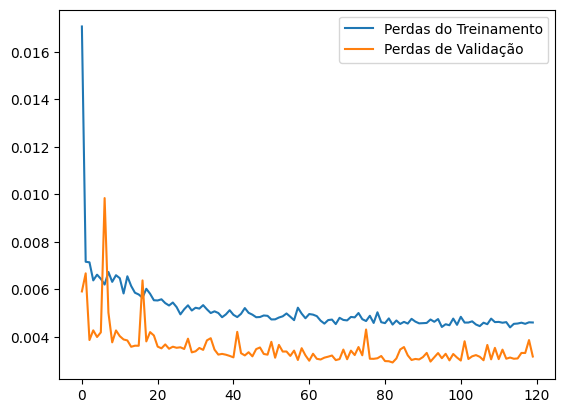

In [16]:
plt.plot(validation.history['loss'], label="Perdas do Treinamento")
plt.plot(validation.history['val_loss'], label="Perdas de Validação")
plt.legend()
plt.show()

In [38]:
#Tentanto Prever
predicoes = model.predict(X_test)
predicoes = scaler.inverse_transform(predicoes)

22/22 [==============================] - 0s 10ms/step


In [19]:
# Obter os valores reais para o conjunto de teste
real_values = scaler.inverse_transform(teste[steps:])

In [29]:
# Preparar os dados para o gráfico comparativo
rmse = np.sqrt(np.mean(prev - Y_test)**2)


In [40]:
# Extract the training data
treinamento = df_cripto_fec.iloc[:qtd_linhas_treino]

# Calculate lengths of the arrays
len_preco_fechamento = len(df_cripto_fec["preco_fechamento"].iloc[qtd_linhas_treino:])
len_predicoes = len(predicoes)

# Print the lengths for debugging
print(f"Length of preco_fechamento: {len_preco_fechamento}")
print(f"Length of predicoes: {len_predicoes}")

# Adjust the lengths if necessary and create the DataFrame
if len_preco_fechamento > len_predicoes:
    df_teste = pd.DataFrame({
        "preco_fechamento": df_cripto_fec["preco_fechamento"].iloc[qtd_linhas_treino:][:len_predicoes],
        "predicoes": predicoes.reshape(len_predicoes)
    })
elif len_preco_fechamento < len_predicoes:
    df_teste = pd.DataFrame({
        "preco_fechamento": df_cripto_fec["preco_fechamento"].iloc[qtd_linhas_treino:],
        "predicoes": predicoes.reshape(len_preco_fechamento)
    })
else:
    df_teste = pd.DataFrame({
        "preco_fechamento": df_cripto_fec["preco_fechamento"].iloc[qtd_linhas_treino:],
        "predicoes": predicoes.reshape(len_predicoes)
    })

# Print the resulting DataFrame for debugging
print(df_teste)


Length of preco_fechamento: 728
Length of predicoes: 683
            preco_fechamento    predicoes
2022-07-05       1134.541016  1651.129272
2022-07-06       1186.973999  1645.692017
2022-07-07       1237.593384  1660.836548
2022-07-08       1222.506226  1643.910278
2022-07-09       1216.978271  1635.278076
...                      ...          ...
2024-05-13       2949.359619  3572.533203
2024-05-14       2881.157959  3505.854248
2024-05-15       3037.056641  3434.785156
2024-05-16       2945.131104  3425.954590
2024-05-17       3094.118652  3438.831055

[683 rows x 2 columns]


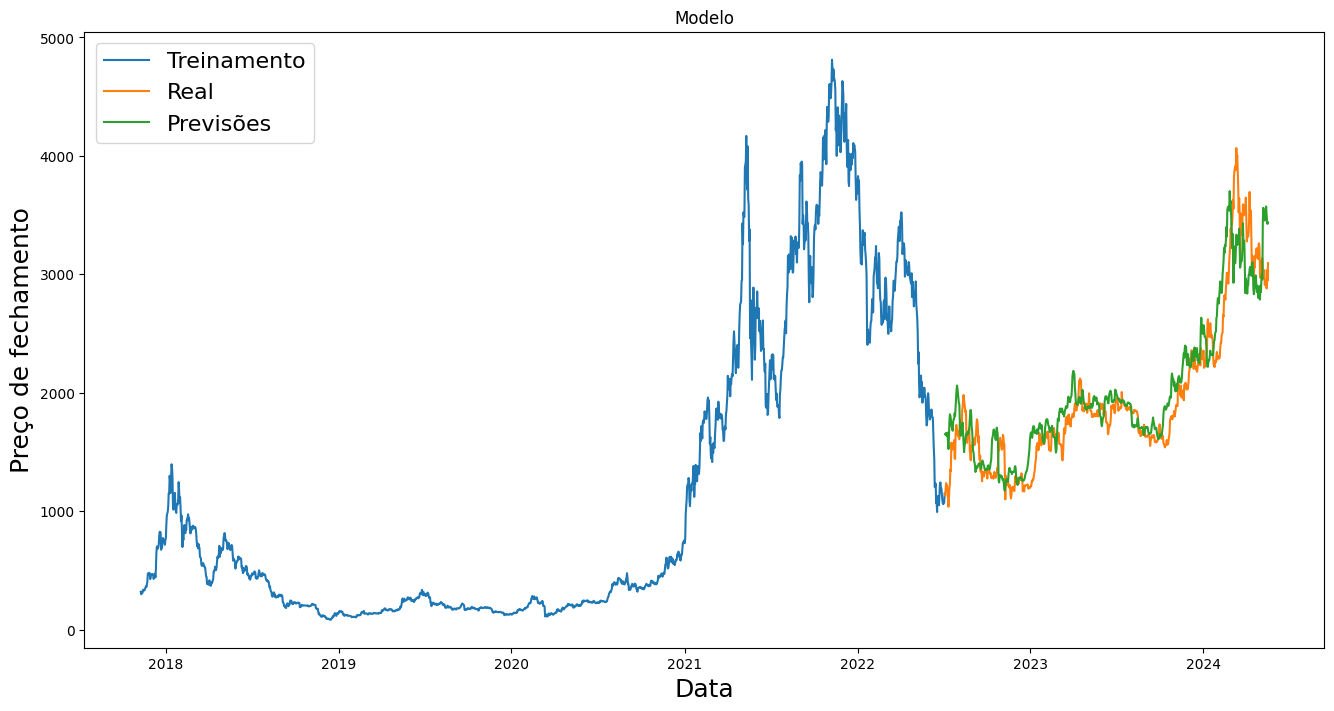

In [41]:
plt.figure(figsize=(16, 8))
plt.title("Modelo")
plt.xlabel('Data', fontsize=18)
plt.ylabel('Preço de fechamento', fontsize=18)
plt.plot(treinamento['preco_fechamento'])
plt.plot(df_teste[['preco_fechamento', 'predicoes']])
plt.legend(['Treinamento', 'Real', 'Previsões'], loc=2, prop={'size': 16})
plt.show()